This file primarily deals with generation of simulated gravitational waveforms of detected, known and confirmed exoplanets. The data has been aggregated from **Exoplanet.eu**

In [ ]:
!pip install pycbc

In [ ]:
"""
readligo.py


Version 0.5
Oct 9, 2018
Jonah Kanner, Roy Williams, Agata Trovato, and Alan Weinstein

Updates in this version:
 * Update so that frame files are read w/ gwpy instead of FR library

This module provides tools for reading LIGO data
files.  Data along with supporting documentation
can be downloaded from the losc web site:
https://losc.ligo.org

Some possible use cases are shown below.

Example #0:
To load all data from a single file:
strain, time, dq = rl.loaddata('ligo_data/H-H1_LOSC_4_V1-842653696-4096.hdf5', 'H1')

Some GWF files require parameters to name the strain, DQ, and hardware injection channgel:
strain, time, dq = rl.loaddata('H-H1_LOSC_16_V1-1127415808-4096.gwf', 'H1', strain_chan='H1:GWOSC-16KHZ_R1_STRAIN',
                                dq_chan='H1:GWOSC-16KHZ_R1_DQMASK', inj_chan='H1:GWOSC-16KHZ_R1_INJMASK')

Example #1:
segList = getsegs(842657792, 842658792, 'H1')
for (start, stop) in segList:
  strain, meta, dq = getstrain(start, stop, 'H1')
  # -- Analysis code here
  ...

This default configuration assumes that the needed LIGO data
files are available in the current working directory or a
subdirectory.  LIGO data between the input GPS times are loaded
into STRAIN.  META is a dictionary of gps start, gps stop, and the
sample time.  DQ is a dictionary of data quality flags.

Example #2
segList = SegmentList('H1_segs.txt')

In Example 2, 'H1_segs.txt' is a segment list downloaded from the
LOSC web site using the Timeline application.  This may be used in the same
manner as segList in example 1.

Example #3
filelist = FileList(directory='/home/ligodata')
segList = getsegs(842657792, 842658792, 'H1', filelist=filelist)
for start, stop in segList:
  strain, meta, dq = getstrain(start, stop, 'H1', filelist=filelist)
  # -- Analysis code here

In this example, the first command searches the indicated directory and
sub-directories for LIGO data files.  This list of data files is then
used to construct a segment list and load the requested data.

-- SEGMENT LISTS --

Segment lists may be downloaded from the LOSC web site
using the Timeline Query Form or constructed directly
from the data files.

Read in a segment list downloaded from the Timeline
application on the LOSC web site with SegmentList:
>> seglist = SegmentList('H1_segs.txt')
OR
Construct a segment list directly from the LIGO
data files with getsegs():
>> seglist = getsegs(842657792, 842658792, 'H1', flag='DATA', filelist=None)

"""

import numpy as np
import os
import fnmatch

def read_frame(filename, ifo, readstrain=True, strain_chan=None, dq_chan=None, inj_chan=None):
    """
    Helper function to read frame files
    """

    from gwpy.timeseries import TimeSeries


    if ifo is None:
        raise TypeError("""To read GWF data, ifo must be 'H1', 'H2', or 'L1'.
        def loaddata(filename, ifo=None):""")

    #-- Read strain channel
    if strain_chan is None:
        strain_chan = ifo + ':LOSC-STRAIN'

    if readstrain:
        try:
            sd = TimeSeries.read(filename, strain_chan)
            strain = sd.value
            gpsStart = sd.t0.value
            ts = sd.dt.value
        except:
            print("ERROR reading file {0} with strain channel {1}".format(filename, strain_chan))
            raise
    else:
        ts = 1
        strain = 0

    #-- Read DQ channel
    if dq_chan is None:
        dq_chan = ifo + ':LOSC-DQMASK'

    try:
        qd = TimeSeries.read(str(filename), str(dq_chan))
        gpsStart = qd.t0.value
        qmask = np.array(qd.value)
        dq_ts = qd.dt.value
        shortnameList_wbit = str(qd.unit).split()
        shortnameList = [name.split(':')[1] for name in shortnameList_wbit]
    except:
        print("ERROR reading DQ channel '{0}' from file: {1}".format(dq_chan, filename))
        raise

    #-- Read Injection channel
    if inj_chan is None:
        inj_chan = ifo + ':LOSC-INJMASK'

    try:
        injdata = TimeSeries.read(str(filename), str(inj_chan))
        injmask = injdata.value
        injnamelist_bit = str(injdata.unit).split()
        injnamelist     = [name.split(':')[1] for name in injnamelist_bit]
    except:
        print("ERROR reading injection channel '{0}' from file: {1}".format(inj_chan, filename))
        raise

    return strain, gpsStart, ts, qmask, shortnameList, injmask, injnamelist

def read_hdf5(filename, readstrain=True):
    """
    Helper function to read HDF5 files
    """
    import h5py
    dataFile = h5py.File(filename, 'r')

    #-- Read the strain
    if readstrain:
        strain = dataFile['strain']['Strain'][...]
    else:
        strain = 0

    ts = dataFile['strain']['Strain'].attrs['Xspacing']

    #-- Read the DQ information
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    shortnameArray = dqInfo['DQShortnames'].value
    shortnameList  = list(shortnameArray)

    # -- Read the INJ information
    injInfo = dataFile['quality/injections']
    injmask = injInfo['Injmask'][...]
    injnameArray = injInfo['InjShortnames'].value
    injnameList  = list(injnameArray)

    #-- Read the meta data
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'].value

    dataFile.close()
    return strain, gpsStart, ts, qmask, shortnameList, injmask, injnameList

def loaddata(filename, ifo=None, tvec=True, readstrain=True, strain_chan=None, dq_chan=None, inj_chan=None):
    """
    The input filename should be a LOSC .hdf5 file or a LOSC .gwf
    file.  The file type will be determined from the extenstion.
    The detector should be H1, H2, or L1.

    The return value is:
    STRAIN, TIME, CHANNEL_DICT

    STRAIN is a vector of strain values
    TIME is a vector of time values to match the STRAIN vector
         unless the flag tvec=False.  In that case, TIME is a
         dictionary of meta values.
    CHANNEL_DICT is a dictionary of data quality channels
    STRAIN_CHAN is the channel name of the strain vector in GWF files.
    DQ_CHAN is the channel name of the data quality vector in GWF files.
    INJ_CHAN is the channel name of the injection vector in GWF files.
    """

    # -- Check for zero length file
    try:
        if os.stat(filename).st_size == 0:
            return None, None, None
    except:
        return None,None,None

    file_ext = os.path.splitext(filename)[1]
    if (file_ext.upper() == '.GWF'):
        strain, gpsStart, ts, qmask, shortnameList, injmask, injnameList = read_frame(filename, ifo, readstrain, strain_chan, dq_chan, inj_chan)
    else:
        strain, gpsStart, ts, qmask, shortnameList, injmask, injnameList = read_hdf5(filename, readstrain)

    #-- Create the time vector
    gpsEnd = gpsStart + len(qmask)
    if tvec:
        time = np.arange(gpsStart, gpsEnd, ts)
    else:
        meta = {}
        meta['start'] = gpsStart
        meta['stop']  = gpsEnd
        meta['dt']    = ts

    #-- Create 1 Hz DQ channel for each DQ and INJ channel
    channel_dict = {}  #-- 1 Hz, mask
    slice_dict   = {}  #-- sampling freq. of stain, a list of slices
    final_one_hz = np.zeros(qmask.shape, dtype='int32')
    for flag in shortnameList:
        bit = shortnameList.index(flag)
        # Special check for python 3
        if isinstance(flag, bytes): flag = flag.decode("utf-8")

        channel_dict[flag] = (qmask >> bit) & 1

    for flag in injnameList:
        bit = injnameList.index(flag)
        # Special check for python 3
        if isinstance(flag, bytes): flag = flag.decode("utf-8")

        channel_dict[flag] = (injmask >> bit) & 1

    #-- Calculate the DEFAULT channel
    try:
        channel_dict['DEFAULT'] = ( channel_dict['DATA'] )
    except:
        print("Warning: Failed to calculate DEFAULT data quality channel")

    if tvec:
        return strain, time, channel_dict
    else:
        return strain, meta, channel_dict


def dq2segs(channel, gps_start):
    """
    This function takes a DQ CHANNEL (as returned by loaddata or getstrain) and
    the GPS_START time of the channel and returns a segment
    list.  The DQ Channel is assumed to be a 1 Hz channel.

    Returns of a list of segment GPS start and stop times.
    """
    #-- Check if the user input a dictionary
    if type(channel) == dict:
        try:
            channel = channel['DEFAULT']
        except:
            print("ERROR: Could not find DEFAULT channel in dictionary")
            raise

    #-- Create the segment list
    segments = dq_channel_to_seglist(channel, fs=1)
    t0 = gps_start
    segList = [(int(seg.start+t0), int(seg.stop+t0)) for seg in segments]
    return SegmentList(segList)

def dq_channel_to_seglist(channel, fs=4096):
    """
    WARNING:
    This function is designed to work the output of the low level function
    LOADDATA, not the output from the main data loading function GETSTRAIN.

    Takes a data quality 1 Hz channel, as returned by
    loaddata, and returns a segment list.  The segment
    list is really a list of slices for the strain
    associated strain vector.

    If CHANNEL is a dictionary instead of a single channel,
    an attempt is made to return a segment list for the DEFAULT
    channel.

    Returns a list of slices which can be used directly with the
    strain and time outputs of LOADDATA.
    """
    #-- Check if the user input a dictionary
    if type(channel) == dict:
        try:
            channel = channel['DEFAULT']
        except:
            print("ERROR: Could not find DEFAULT channel in dictionary")
            raise

    # -- Create the segment list
    condition = channel > 0
    boundaries = np.where(np.diff(condition) == True)[0]
    # -- Need to +1 due to how np.diff works
    boundaries = boundaries + 1
    # if the array "begins" True, we need to complete the first segment
    if condition[0]:
        boundaries = np.append(0,boundaries)
    # if the array "ends" True, we need to complete the last segment
    if condition[-1]:
        boundaries = np.append(boundaries,len(condition))

    # -- group the segment boundaries two by two
    segments = boundaries.reshape( ( len(boundaries) // 2, 2 ) ) #// for python 3
    # -- Account for sampling frequency and return a slice
    segment_list = [slice(start*fs, stop*fs) for (start,stop) in segments]

    return segment_list

class FileList():
    """
    Class for lists of LIGO data files.

    When a FileList instance is created, DIRECTORY will
    be searched for LIGO data files.  Sub-directories
    will be searched as well.  By default, the current
    working directory is searched.
    """
    def __init__(self, directory=None, cache=None):

        # -- Set default directory
        if directory is None:
            if os.path.isdir('/archive/losc/strain-gwf'):
                directory='/archive/losc/strain-gwf'
            else:
                directory='.'

        print("Using data directory {0} ...".format(directory))
        self.directory = directory
        self.cache = cache
        if cache is None:
            self.list = self.searchdir(directory)
        else:
            self.readcache()

    def searchdir(self, directory='.'):
        frameList = []
        hdfList   = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, '*.gwf'):
                frameList.append(os.path.join(root, filename))
            for filename in fnmatch.filter(filenames, '*.hdf5'):
                hdfList.append(os.path.join(root, filename))
        return frameList + hdfList

    def writecache(self, cacheName):
        outfile = open(cacheName, 'w')
        for file in self.list:
            outfile.write(file + '\n')
        outfile.close()

    def readcache(self):
        infile = open(self.cache, 'r')
        self.list = infile.read().split()
        infile.close()

    def findfile(self, gps, ifo):
        start_gps = gps - (gps % 4096)
        filenamelist = fnmatch.filter(self.list, '*' + '-' + ifo + '*' + '-' + str(start_gps) + '-' + '*')
        if len(filenamelist) == 0:
            print("WARNING!  No file found for GPS {0} and IFO {1}".format(gps, ifo))
            return None
        else:
            return filenamelist[0]

def getstrain(start, stop, ifo, filelist=None, strain_chan=None, dq_chan=None, inj_chan=None):
    """
    START should be the starting gps time of the data to be loaded.
    STOP  should be the end gps time of the data to be loaded.
    IFO should be 'H1', 'H2', or 'L1'.
    FILELIST is an optional argument that is a FileList() instance.
    STRAIN_CHAN is the channel name of the strain vector in GWF files.
    DQ_CHAN is the channel name of the data quality vector in GWF files.
    INJ_CHAN is the channel name of the injection vector in GWF files.

    The return value is (strain, meta, dq)

    STRAIN: The data as a strain time series
    META: A dictionary of meta data, especially the start time, stop time,
          and sample time
    DQ: A dictionary of the data quality flags
    """

    if filelist is None:
        filelist = FileList()

    # -- Check if this is a science segment
    segList = getsegs(start, stop, ifo, flag='DATA', filelist=filelist, strain_chan=strain_chan, dq_chan=dq_chan, inj_chan=inj_chan)
    sl = segList.seglist
    if (sl[0][0] == start) and (sl[0][1] == stop):
        pass
    else:
        raise TypeError("""Error in getstrain.
        Requested times include times where the data file was not found
        or instrument not in SCIENCE mode.
        Use readligo.getsegs() to construct a segment list.
        The science mode segment list for the requested time range is:
        {0}""".format(segList))

    # -- Construct list of expected file start times
    first = start - (start % 4096)
    gpsList = np.arange(first, stop, 4096)

    m_strain = np.array([])
    m_dq     = None
    # -- Loop over needed files
    for time in gpsList:
        filename = filelist.findfile(time, ifo)
        print("Loading {0}".format(filename))

        #-- Read in data
        strain, meta, dq = loaddata(filename, ifo, tvec=False, strain_chan=strain_chan, dq_chan=dq_chan, inj_chan=inj_chan)
        if len(m_strain) == 0:
            m_start = meta['start']
            dt = meta['dt']
        m_stop = meta['stop']
        m_strain = np.append(m_strain, strain)
        if m_dq is None:
            m_dq = dq
        else:
            for key in dq.keys():
                m_dq[key] = np.append(m_dq[key], dq[key])

    # -- Trim the data
    lndx  = np.abs(start - m_start)*(1.0/dt)
    rndx = np.abs(stop - m_start)*(1.0/dt)

    m_strain = m_strain[int(lndx):int(rndx)] # slice indices must be integers
    for key in m_dq.keys():
        m_dq[key] = m_dq[key][int(lndx*dt):int(rndx*dt)]# slice indices must be integers

    meta['start'] = start
    meta['stop']  = stop
    meta['dt']    = dt

    return m_strain, meta, m_dq

class SegmentList():
    def __init__(self, filename, numcolumns=3):

        if type(filename) is str:
            try:
                if numcolumns == 4:
                    number, start, stop, duration = np.loadtxt(filename, dtype='int',unpack=True)
                elif numcolumns == 2:
                    start, stop = np.loadtxt(filename, dtype='int',unpack=True)
                elif numcolumns == 3:
                    start, stop, duration = np.loadtxt(filename, dtype='int',unpack=True)
                if isinstance(start, int):
                    self.seglist = [[start, stop]]
                else:
                    self.seglist = zip(start, stop)
            except:
                self.seglist = []
        elif type(filename) is list:
            self.seglist = filename
        else:
            raise TypeError("SegmentList() expects the name of a segmentlist file from the LOSC website Timeline")

    def __repr__(self):
        return 'SegmentList( {0} )'.format(self.seglist)
    def __iter__(self):
        return iter(self.seglist)
    def __getitem__(self, key):
        return self.seglist[key]

def getsegs(start, stop, ifo, flag='DATA', filelist=None, strain_chan=None, dq_chan=None, inj_chan=None):
    """
    Method for constructing a segment list from
    LOSC data files.  By default, the method uses
    files in the current working directory to
    construct a segment list.

    If a FileList is passed in the flag FILELIST,
    then those files will be searched for segments
    passing the DQ flag passed as the FLAG argument.

    START is the start time GPS
    STOP is the stop time GPS
    STRAIN_CHAN is the channel name of the strain vector in GWF files.
    DQ_CHAN is the channel name of the data quality vector in GWF files.
    INJ_CHAN is the channel name of the injection vector in GWF files.
    """

    if filelist is None:
        filelist = FileList()

    # -- Construct list of expected file start times
    first = start - (start % 4096)
    gpsList = np.arange(first, stop, 4096)
    m_dq     = None

    # -- Initialize segment list
    segList = []

    # -- Loop over needed files
    for time in gpsList:
        filename = filelist.findfile(time, ifo)

        #-- Read in data
        if filename is None:
            print("WARNING! No file found with GPS start time {0}".format(time))
            continue
        else:
            try:
                strain, meta, dq = loaddata(filename, ifo, tvec=False, readstrain=False, strain_chan=strain_chan, dq_chan=dq_chan, inj_chan=inj_chan)
            except:
                print("WARNING! Failed to load file {0}".format(filename))
                continue

        if dq is None:
            print("Warning! Found zero length file {0}".format(filename))
            print("Segment list may contain errors.")
            continue

        #-- Add segments to list on a file-by-file basis
        chan = dq[flag]
        indxlist = dq_channel_to_seglist(chan, fs=1.0)
        i_start = meta['start']
        i_seglist = [(indx.start+i_start, indx.stop+i_start) for indx in indxlist]
        i_seglist = [(int(begin), int(end)) for begin, end in i_seglist]
        segList = segList + i_seglist

    # -- Sort segments
    segList.sort()

    # -- Merge overlapping segments
    for i in range(0, len(segList)-1):
        seg1 = segList[i]
        seg2 = segList[i+1]

        if seg1[1] == seg2[0]:
            segList[i]   = None
            segList[i+1] = (seg1[0], seg2[1])
    # -- Remove placeholder segments
    segList = [seg for seg in segList if seg is not None]

    # -- Trim segment list to fit within requested start/stop times
    for seg in segList:
        idx = segList.index(seg)
        if (seg[1] < start):
            segList[idx] = None
        elif (seg[0] > stop):
            segList[idx] = None
        elif (seg[0] < start) and (seg[1] > stop):
            segList[idx] = (start, stop)
        elif (seg[0] < start):
            segList[idx] = (start, seg[1])
        elif (seg[1] > stop):
            segList[idx] = (seg[0], stop)
    # -- Remove placeholder segments
    segList = [seg for seg in segList if seg is not None]

    return SegmentList(segList)

In [ ]:
import numpy as np
from scipy import signal
import pycbc.psd, pycbc.noise
from pycbc.types import TimeSeries
from numpy import pi
from pycbc.waveform import get_td_waveform



class waveformGenerator(object):

    #generates TimeSeries of 1s duration with delta_t = 1/4096

    def generate_SineGaussianBlip(fc, bw, duration):

        #returns sine gaussian blip with bandwidth = bw, centre frequency = fc

        t = np.linspace(-duration/2, duration/2, duration*4096)
        sine_gaussian = signal.gausspulse(t, fc=fc, bw=bw)
        waveform = TimeSeries(sine_gaussian, delta_t=1/4096)
        return waveform

    def generate_FrequencyLine(freq, duration):

        #returns a sine wave with frequency = freq

        t = np.linspace(0, duration, duration*4096)
        freq_line = np.sin(t*2*pi*freq)
        waveform = TimeSeries(freq_line, delta_t=1/4096)
        return waveform

    def generate_GWChirp(m1, m2):

        #returns + polarization of the gw chirp
        hp, hc = get_td_waveform(approximant='SEOBNRv4_opt', mass1=m1, mass2=m2, delta_t=1/4096, f_lower = 20 )
        return hp

    def generate_Impulse(position, duration):

        #returns an impusle signal with duration = durationa and position = position

        impulse = signal.impulse(duration,position)
        waveform = TimeSeries(impulse, delta_t=1/4096)
        return waveform

    def generate_Whistle(f_lower,bw, duration, tc =0.5):
        '''
        f_lower: lower frequency
        tc: fractional center time position (time at which fequency is min)
        bw: bandwidth in frequency domian'''

        t = np.linspace(0, duration, duration*4096)
        omega = f_lower + 2*pi*(bw/tc**2)*(t - tc*duration)**2
        whistle = np.sin(omega*t)
        waveform = TimeSeries(whistle, delta_t=1/4096)
        return waveform

    def generate_Noise(duration, delta_f, delta_t, f_min):
        flen = int(2048/delta_f) +1
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
        tsamples = int(duration / delta_t)
        ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
        return ts

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'


class CNN1d(nn.Module):
    # inspired by https://www.kaggle.com/scaomath/g2net-1d-cnn-gem-pool-pytorch-train-inference
    def __init__(self):
        super().__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32),
            GeM(kernel_size=2),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )

        self.cnn3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )

        self.t1 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32),
            GeM(kernel_size=4),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Conv1d(64, 128, kernel_size=32),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )

        self.cnn4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=16),
            GeM(kernel_size=6),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )


        self.cnn5 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=16),
            nn.BatchNorm1d(256),
        )

        self.gru = nn.GRU(256, 128, bidirectional=True,
                          batch_first=True)

        self.cnn6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=16),
            GeM(kernel_size=4),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )

        self.cnn7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )

        self.fc = nn.Linear(256*10, 2048)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.t1(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.gru(x.transpose(2, 1))[0].transpose(2, 1)
        x = self.cnn6(x)
        x = self.cnn7(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn1 = CNN1d()
        self.cnn2 = CNN1d()

        sizes = [2048] + [3192] * 3
        # projector
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)
        self.lambd = 0.0051
        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, x, label=None, mode='train'):
        if mode != 'train':
            z1 = self.cnn1(x[:, 0:1])
            z2 = self.cnn1(x[:, 1:2])
            z3 = self.cnn2(x[:, 2:3])
            return z1, z2, z3

        z1 = self.projector(self.cnn1(x[:, 0:1]))
        z2 = self.projector(self.cnn2(x[:, 1:2]))
        # empirical cross-correlation matrix
        c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        c.div_(z1.shape[0])

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = on_diag + self.lambd * off_diag
        return loss


class NetEval(nn.Module):
    def __init__(self, weight_paths,
                 mode='train'):
        super(NetEval, self).__init__()
        self.backbone = Net()
        if mode=='train':
            from utils import average_model
            averaged_w = average_model(weight_paths)
            self.backbone.load_state_dict(averaged_w)
            del averaged_w
        self.backbone.eval()
        self.fc = nn.Linear(2048*3, 1)

    def forward(self, x, mode='val'):
        with torch.no_grad():
            z1, z2, z3 = self.backbone(x, mode='val')
        return self.fc(torch.cat([z1, z2, z3], -1))


if __name__ == "__main__":
    bsz = 16
    x = torch.randn(bsz, 3, 4096)
    y = torch.zeros((bsz,))
    model = Net()
    loss = model(x)
    print(loss)
    z1, z2, z3 = model(x, mode='val')
    print(z1.shape)

    model = NetEval(None, mode='val')
    pred = model(x)
    print(pred.shape)

tensor(6868.8872, grad_fn=<AddBackward0>)
torch.Size([16, 2048])
torch.Size([16, 1])


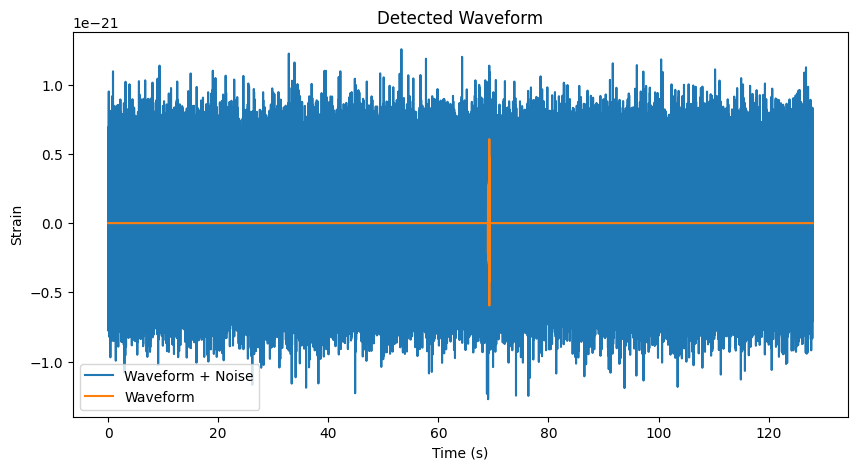

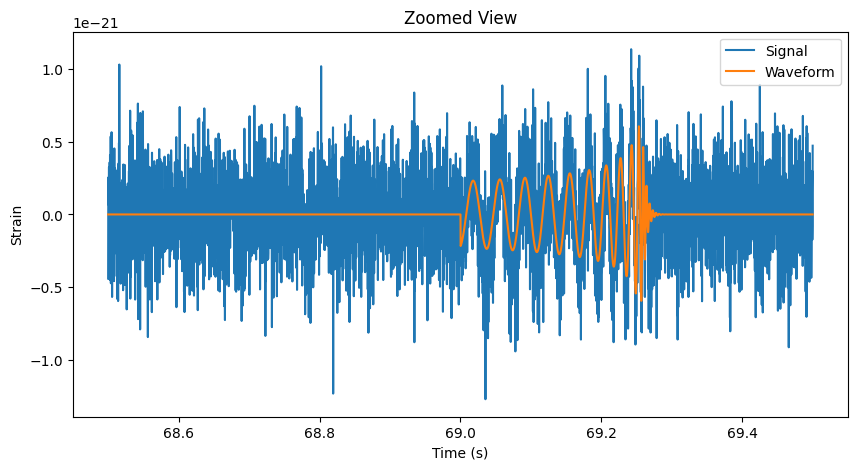

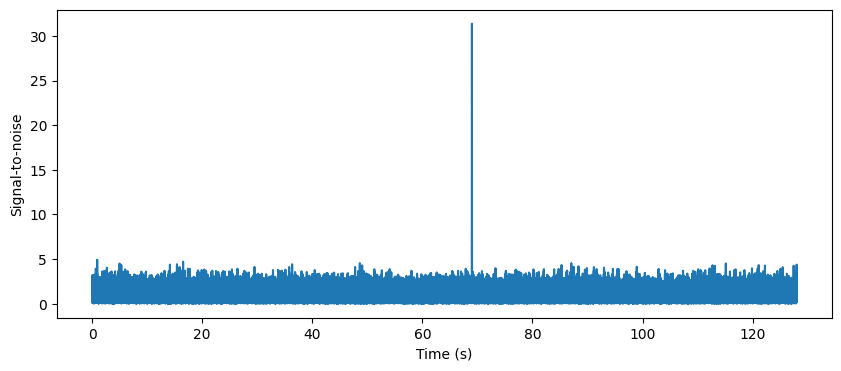

In [ ]:
import pylab
import numpy
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries
from pycbc.types import real_same_precision_as
from pycbc.filter import matchedfilter
from pycbc.psd import interpolate
from pycbc.filter import matched_filter


def generate_Noise(duration, delta_f, delta_t, f_min):
    flen = int(2048/delta_f) +1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    tsamples = int(duration / delta_t)
    ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
    return ts

mass = 40

f_min = 20
time_duration = 128
f_sample = 4096
f_max = f_sample/2
delta_t = 1/f_sample
delta_f = 1/time_duration

hp, hc = get_td_waveform(approximant='SEOBNRv4_opt', mass1=mass, mass2=mass, delta_t= delta_t, f_lower = 25, distance=100)
noise = generate_Noise(time_duration, delta_f, delta_t, f_min)

merger_time = (1/4096) * hp.numpy().argmax()
snr = 30

hp_size = len(hp)
hp.resize(time_duration*f_sample)
psd = noise.psd(4)
psd = interpolate(psd, hp.delta_f)
sigma = matchedfilter.sigma(hp, psd = psd, low_frequency_cutoff=f_min)
Amplitude = snr/(sigma)


hp *= Amplitude

hp.resize(hp_size)
merger_time = 69
merger_index = int(69/delta_t) +1
start_index = merger_index + len(hp)
waveform = TimeSeries(numpy.zeros(len(noise)), delta_t=delta_t, \
        dtype=real_same_precision_as(noise))


waveform[merger_index :start_index] = hp

signal = noise + waveform

pylab.figure(figsize=(10,5))
pylab.plot(signal.sample_times,signal,label='Waveform + Noise')
pylab.plot(waveform.sample_times,waveform,label='Waveform')

pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Detected Waveform')


zoom_signal = signal.time_slice(merger_time-0.5,merger_time+0.5)
zoom_waveform = waveform.time_slice(merger_time-0.5,merger_time+0.5)
pylab.figure(figsize=(10,5))
pylab.plot(zoom_signal.sample_times,zoom_signal,label='Signal')
pylab.plot(zoom_waveform.sample_times,zoom_waveform,label='Waveform')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Zoomed View')
pylab.legend()

hp.resize(time_duration*f_sample)
snr = matched_filter(hp, signal,
                     psd=psd, low_frequency_cutoff=20)



pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
